# Import libraries

In [5]:
import os
import pandas as pd
import re
import random
import numpy as np

from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
file = "../data/jigsaw-toxic-comment-classification-challenge/train.csv"
data = pd.read_csv(file)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Exploration

Count the number of toxic and non toxic comments in the dataset

In [4]:
rowsums=data.iloc[:,2:].sum(axis=1)
all_zero =(rowsums==0)
print("Total of comments, ",len(data))
print("Total number of non toxic comments: ", all_zero.sum())
print("Total number of toxic comments: ", rowsums.sum())

Total of comments,  159571
Total number of non toxic comments:  143346
Total number of toxic comments:  35098


In [6]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [10]:
print("Number of rows with multiple labling: ", (rowsums > 1).sum())

Number of rows with multiple labling:  9865


We can see that multiple tweets have more than one classification and we can see many classfications in the toxic comments, however we only need to classify between toxic and non-toxic comments.

# Preprocessing

We are going to devide the dataset to just one class, instead of 6.   
The class Toxic has two posible values:   
0: Non-toxic comment   
1: Toxic comment   
   
The other 6 columns are droped out (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate)   
If the tweet has at least one non-zero value in any of the 6 last classes, it is set as 1 in the new class, otherwise as 0.

In [151]:
def typeComment(df):
    # If the comment has value more than 0, then it is  toxic. Otherwise non-toxic
    score=list(df.sum(axis = 1, skipna = True))
    new_score = [1 if (x>0) else 0 for x in score]
    return(new_score)
data['Toxic'] = typeComment(data)
toxic_columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
data = data.drop(columns=toxic_columns)
data.head()

,id,comment_text,Toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [8]:
data.dtypes

id              object
comment_text    object
Toxic            int64
dtype: object

All the special chars will be deleted.   
The regular expressions (RE_PATTERNS) are for the more common words which can be written in multiple ways for the toxic comments.

In [72]:
special_chars = r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]"
RE_PATTERNS = {
    ' fuck':['(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)','(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            'feck ', ' fux ', 'f\*\*', 'f\-ing', 'f u u c', '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',' fu ',
            'f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f\.u\.', 'f###', 'f@ck', 'f u c k', 'f uck', 'f ck' ],
    ' ass ':['[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$', '[^a-z]anus', ' a\*s\*s', 
        '[^a-z]ass[^a-z ]', 'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'],
    ' ass hole ':[' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole'],
    ' bitch ':['(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)', 'b!tch','bi\+ch', 'b!\+ch',
               'b[w]*i[t]*ch','biatch', 'bi\*\*h', 'bytch', 'b i t c h'],
    ' bastard ':['ba[s|z]+t[e|a]+rd'],
    ' dick ':[' dick[^aeiou]', 'deek', 'd i c k'],
    ' suck ':[ 'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'],
    ' cunt ':['c u n t'],
    ' bull shit ':[ 'bullsh\*t', 'bull\$hit'],
    ' idiot ':['i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)','idiots','i d i o t'],
    ' cock ':['[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'],
    ' dumb ':['(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'],
    ' shit ':['shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'],
    ' shit hole ':['shythole'],
    ' retard ':['returd', 'retad', 'retard', 'wiktard', 'wikitud'],
    ' rape ':['raped'],
    ' dumb ass':['dumbass', 'dubass'],
    ' ass head':['butthead'],
    ' nigger ':['nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'],
    ' shut the fuck up': ['stfu'],
    ' pussy ': ['pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'],
    ' faggot ':['faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',],
    ' mother fucker':[' motha ', ' motha f', ' mother f', 'motherucker'],
    ' whore ':['wh\*\*\*', 'w h o r e'],
    ' ':['h[\S]+//[\S]+']
}

In [73]:
class preprocessing(object):
    def __init__(self,special_chars, pattern):
        self.pattern = pattern
        self.special_chars = special_chars
    def cleanString(self,s):
        # remove special chars
        if self.special_chars is not None:
            s = re.sub(self.special_chars, ' ', s)
        s = s.replace("\\n", " ").replace("\n", " ")
        # Regular expressions
        pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
        s = pattern.sub(r"\1", s)
        tokenizer = TweetTokenizer()
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
        return " ".join(cleaned_words)

    def stemWords(self,sentence):
        stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
        stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
        return " ".join(stemmed_words)

    def cleanFrame(selfdev,frame):
        frame['clean_comment'] = frame.comment_text.apply(selfdev.cleanString)

    def stemFrame(selfdev,frame):
        frame['stem_comment'] = frame.clean_comment.apply(selfdev.stemWords)


In [ ]:
Preprocessing=preprocessing(special_chars, RE_PATTERNS)
Preprocessing.cleanFrame(data)
Preprocessing.stemFrame(data)

The function cleanString hands with the special characters, regular expressions, stop words (for English).
The function stemWords stems the words already cleaned.
cleanFrame adds a new column "clean_comment", with the tweets already cleaned by applying the function cleanString
stemFrame got the new clean "clean_comment" from cleanFrame and apply in it stemWords, this is saved in a new column "stem_comment", this is the one which is going to be used for the classification.

In [16]:
data.head()

,id,comment_text,Toxic,clean_comment,stem_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,xplanation hy edits made username ardcore etal...,xplanat hy edit made usernam ardcor etallica r...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,' aww ! e matches background colour ' seemingl...,' aww ! e match background colour ' seemingli ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,"ey man , ' really trying edit war . t's guy co...","ey man , ' realli tri edit war . t' guy consta..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,ore can't make real suggestions improvement - ...,ore can't make real suggest improv - wonder se...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"ou , sir , hero . ny chance remember page that's","ou , sir , hero . ny chanc rememb page that'"


# Save data in a pickle

In [92]:
import pickle
toxic_comments_file = open('classify.pickle','wb') 
toxic_comments = df
pickle.dump(toxic_comments, toxic_comments_file)

# Load data

In [48]:
import pickle

path = "../data/toxic/"
toxic_comments_fread = open(path + 'toxic_comments.pickle','rb') 
data = pickle.load(toxic_comments_fread)
data.head()

,id,comment_text,Toxic,clean_comment,stem_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,xplanation hy edits made username ardcore etal...,xplanat hy edit made usernam ardcor etallica r...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,' aww ! e matches background colour ' seemingl...,' aww ! e match background colour ' seemingli ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,"ey man , ' really trying edit war . t's guy co...","ey man , ' realli tri edit war . t' guy consta..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,ore can't make real suggestions improvement - ...,ore can't make real suggest improv - wonder se...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"ou , sir , hero . ny chance remember page that's","ou , sir , hero . ny chanc rememb page that'"


In [50]:
data.Toxic.value_counts()


0    143346
1     16225
Name: Toxic, dtype: int64

In [51]:
pos = data[data.Toxic==0]
neg = data[data.Toxic==1]


In [55]:
pos_bal=pos.sample(len(neg))
len(pos_bal)

16225

In [57]:
df = pd.concat([pos_bal, neg])
df

,id,comment_text,Toxic,clean_comment,stem_comment
72495,c20237b799a40828,"Re: Strawberry Flower \n\nEh, I got to look mo...",0,"e trawberry lower h , got look carefully next ...","e trawberri lower h , got look care next time ..."
125941,a19c54add545bc04,"""\n\nAddendum: Changed definition of 'palpitat...",0,ddendum hanged definition ' palpitations ' par...,ddendum hang definit ' palpit ' parenthes sudd...
74866,c842a56996d5551f,please help\nI have changed the name and forma...,0,please help changed name format image want upl...,pleas help chang name format imag want upload ...
87381,e9ca0e568c18f3d4,"In my opinion, Nmate does not like Slovak edit...",0,"n opinion , mate like lovak editors look block...","n opinion , mate like lovak editor look block ..."
56464,96dd9a387152e8fa,"""\n\nExcellent points Delirum. airline busine...",0,xcellent points elirum . airline business crea...,xcellent point elirum . airlin busi creat expl...
...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,previous conversation fucking shit eating libe...,"previou convers fuck shit eat liber , make lad..."
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,,
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,absurd edits absurd edits great white shark to...,absurd edit absurd edit great white shark tota...
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,ey listen ever ! elete edits ever ' annoyed 2 ...,ey listen ever ! elet edit ever ' annoy 2 15 r...


# Vectorize

The data is split for training and test with a rate 80-20.

In [13]:

X_train, X_test, y_train, y_test = train_test_split(data.stem_comment, data.Toxic, test_size=0.2,
                                                    random_state=np.random)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(25960,) (6490,) 25960 6490


In [14]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [15]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
max(totalNumWords)

1078

The max number of words in a comment is 1333, however this is too long to be worked with all the tweets with that extension, and this means several 0 values in almost all the tweets, so we decided to explore the distribution in all the tweets so cut the vectors to a defined lenght.   
This lenght (maxlen) must represent almot all the information but with a significative reduction. of space.

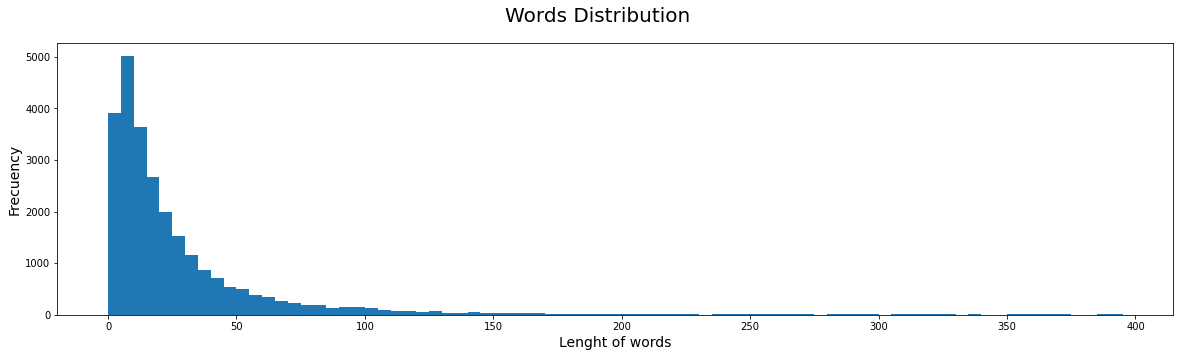

In [16]:
fig= plt.figure(figsize=(20,5))
fig.suptitle('Words Distribution', fontsize=20)
plt.xlabel('Lenght of words', fontsize=14)
plt.ylabel('Frecuency', fontsize=14)
plt.hist(totalNumWords,bins = np.arange(0,400,5))#(0,1300,5)
plt.show()

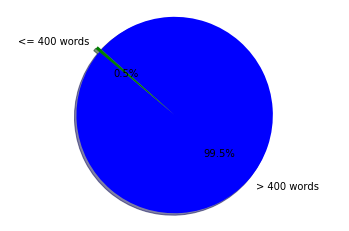

In [17]:
maxlen=400
counter=0
for i in totalNumWords:
    if i>=maxlen:
        counter+=1
        
labels = ['> 400 words','<= 400 words']
sizes = [len(totalNumWords),counter]
colors = ['blue', 'green']
# Data to plot
explode = (0, 0.05)  # explode 1st slice
fig.suptitle('Words Distribution', fontsize=20)

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

After Analyze the distribution, we decided to set the maxlen in 400, this means a reduction of 70% in the lenght for the vectors, and this cut off only affects to the 0.3% of the data, afther this maxlens this percentage decrease too slowly.

In [18]:
class ModelROC:
    def __init__(self, model, X_test, y_test, legend):
        self.model = model
        y_pred = self.getPredictions(X_test)
        fpr, tpr, treshold = roc_curve(y_test, y_pred)
        self.fpr = fpr
        self.tpr = tpr
        self.treshold = treshold
        self.auc = auc(fpr, tpr)
        self.legend = legend
        print("Area under the curve " + self.legend + " " + str(self.auc))
    
    def getPredictions(self, X_test):
        return self.model.predict(X_test)
    
    def plotData(self):
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr, self.tpr, label= self.legend + ' (area = {:.3f})'.format(self.auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        
    def plot(self):
        plt.figure(1)
        self.plotData()
        plt.show()

In [19]:
V_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
V_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(V_train.shape,V_test.shape)

(25960, 400) (6490, 400)


In [20]:
def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(40, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [22]:
model = getModel()
batch_size = 32
epochs = 5

file_path="weights_classification.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


callbacks_list = [checkpoint, early] #early
model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, 
          validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

Train on 23364 samples, validate on 2596 samples
Epoch 1/5
23364/23364 [==============================] - 238s 10ms/step - loss: 0.3868 - accuracy: 0.8273 - val_loss: 0.2607 - val_accuracy: 0.8995

Epoch 00001: val_loss improved from inf to 0.26069, saving model to weights_classification.hdf5
Epoch 2/5
23364/23364 [==============================] - 245s 10ms/step - loss: 0.2110 - accuracy: 0.9219 - val_loss: 0.2634 - val_accuracy: 0.8971

Epoch 00002: val_loss did not improve from 0.26069
Epoch 3/5
23364/23364 [==============================] - 281s 12ms/step - loss: 0.1472 - accuracy: 0.9486 - val_loss: 0.2912 - val_accuracy: 0.8914

Epoch 00003: val_loss did not improve from 0.26069
Epoch 00003: early stopping


# Load the model

In [68]:
file_path="weights_api.hdf5"

from keras.models import load_model
saved_model = load_model(file_path)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [24]:
saved_model.get_weights()

[array([[-0.07413909,  0.16162023, -0.1777963 , ...,  0.04969995,
          0.14006114,  0.02422923],
        [-0.15044409, -0.02464372, -0.08007687, ..., -0.04662025,
         -0.136677  ,  0.03893115],
        [-0.02995637,  0.13854466,  0.02188737, ...,  0.01868676,
          0.3077203 , -0.02207668],
        ...,
        [-0.04165664,  0.04050368, -0.025482  , ..., -0.06914379,
          0.03113838, -0.08127668],
        [-0.02522345,  0.04179887,  0.01084474, ..., -0.01730485,
         -0.05865371,  0.00308488],
        [ 0.00193498, -0.01483714, -0.01129957, ...,  0.02008013,
         -0.02722938,  0.00138384]], dtype=float32),
 array([[ 0.14743716,  0.1734841 ,  0.22478229, ..., -0.10646226,
         -0.00281954,  0.08324804],
        [ 0.01918588, -0.02330021,  0.06261415, ..., -0.05885775,
          0.00412886, -0.03420847],
        [-0.04113455,  0.11175877,  0.01817222, ...,  0.01827945,
         -0.04620684,  0.06834776],
        ...,
        [ 0.01189657,  0.26097432,  0.2

In [24]:
saved_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2440      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0   

In [46]:
saved_model.evaluate(V_test, y_test, verbose=1, use_multiprocessing=False)

6490/6490 [==============================] - 18s 3ms/step


[0.2733130290622153, 0.8838212490081787]

Area under the curve Keras 0.954521688311787


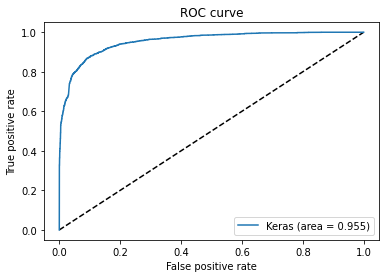

In [47]:
km = ModelROC(model, V_test, y_test, "Keras")
km.plot()

# Classification Report

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

y_pred = saved_model.predict(V_test)
print(classification_report(y_test,y_pred.round(),digits=2))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3188
           1       0.88      0.89      0.89      3302

    accuracy                           0.88      6490
   macro avg       0.88      0.88      0.88      6490
weighted avg       0.88      0.88      0.88      6490



View of the predicted toxic comments

In [80]:
for i,id in enumerate(X_test.index):
    print("\tToxic" if (y_test[id]==1) else "\tNon-toxic")
    print(data["comment_text"][id])

	Non-toxic
Yes, that is true, with Eternal sin as one of the avenues that gets there. But after this experience, the blocked user and all, I will sure not even try to start that article. Please feel free to start that if you like.
	Toxic
hmm... 

What sort of lame duck faggot asher do we have here the? It seems we have a friendless nerd who sits in front of his PC all day jacking off to porn, unless of course, a change happens in Wikipedia, shlock horror!!!!!!! Thenm its an instant orgasm and he has to clean his keyboard up from all the cum stains. 

(did I mention that he likes to finger dogs arses? No, well now you know.)
	Non-toxic
Ok, I've asked him for it, but what do you want me to send you an E-mail about?
	Non-toxic
"
Hey, I'm a Yank, and I've followed Michael Caine's career from a long time ago, possibly before you were born, and I'm telling you that Laurie's grasp of our talk is remarkable. Caine's a great actor, but he's never achieved the ""assimilation"" of our speech patt

In [ ]:
for i,id in enumerate(X_test.index):
    print(df[comment_text][id])
    if y_pred[i].round()==1:
        print("\Toxic: ")

In [27]:
otro[10]

0

In [26]:
otro=list(y_test)

In [31]:
otru=V_test[10]
otru.shape

(400,)

In [33]:
V_test.shape

(31915, 400)

In [35]:
type(otru)

numpy.ndarray

In [38]:
nuevo=otru.reshape(1,400)
nuevo.shape

(1, 400)

In [40]:
type(nuevo)

numpy.ndarray

In [6]:
text="i do not know why you say hat"

preprossed_ds = open('classify.pickle','rb') 
df = pickle.load(preprossed_ds)

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df.stem_comment))
list_tokenized = tokenizer.texts_to_sequences([text])
maxlen=400
V_data = pad_sequences(list_tokenized, maxlen=maxlen)
from sklearn.pipeline import Pipeline
from keras.models import load_model
saved_model = load_model("weights_api.hdf5")
y_pred = model.predict(V_data)
y_pred.sum()/len(y_pred)

TypeError: ('Keyword argument not understood:', 'data_format')

In [82]:
y_pred

array([[0.997168]], dtype=float32)

In [47]:
V_test.shape

(31915, 400)

In [98]:
import keras
print(keras.__version__)

2.3.1


In [99]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
import pickle
def stuff(text):
	preprossed_ds = open('classify.pickle','rb') 
	df = pickle.load(preprossed_ds)

	max_features = 20000
	tokenizer = Tokenizer(num_words=max_features)
	tokenizer.fit_on_texts(list(df.stem_comment))
	list_tokenized = tokenizer.texts_to_sequences([text])
	maxlen=400
	V_data = pad_sequences(list_tokenized, maxlen=maxlen)

	file_path="weights_api.hdf5"

	from keras.models import load_model
	saved_model = load_model(file_path)


	from sklearn.pipeline import Pipeline

	y_pred = model.predict(V_data)
	return y_pred

stuff("Fuck your mouth")

TypeError: ('Keyword argument not understood:', 'data_format')

In [105]:
from platform import python_version

print(python_version())

3.6.9


In [109]:
saved_model = load_model("weights_api.hdf5")

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
